In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from alphacsc import learn_d_z, BatchCDL
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path

from transphorm.model_components.model_modules import CDLTrainer, CDLAnalyzer, calculate_mse_list


from transphorm.preprocessors.loaders import AADataLoader
from transphorm.analyzers import ARHMMAnalyzer
from dotenv import load_dotenv

load_dotenv()


True

In [3]:
# model_path = Path("/projects/p31961/transphorm/models/arhmm/mutual_title_6196.joblib")
data_path = Path("/Users/mds8301/Desktop/temp/da_full_timeseries_partitioned_learning.pt")
# model = joblib.load(model_path)
loader = AADataLoader(data_path,
                      butter_filter=True, 
                      weiner_filter=True,
                      weiner_window_size=1000,
                      smoothing=True,
                      smoothing_window_size=250,
                      down_sample=True, 
                      down_sample_factor=500)
loader.load_data()
loader.prepare_data()


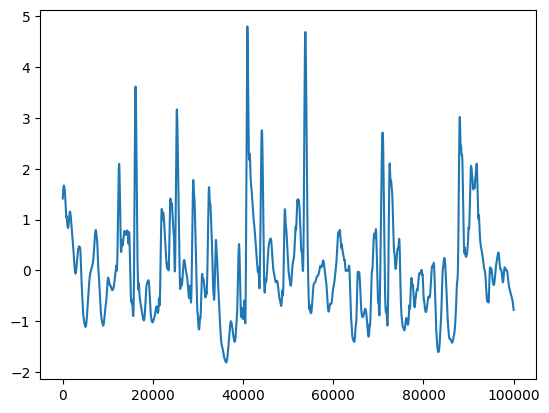

In [11]:

end_idx = 100000
xt = loader.train[0][:end_idx]
plt.plot(xt)

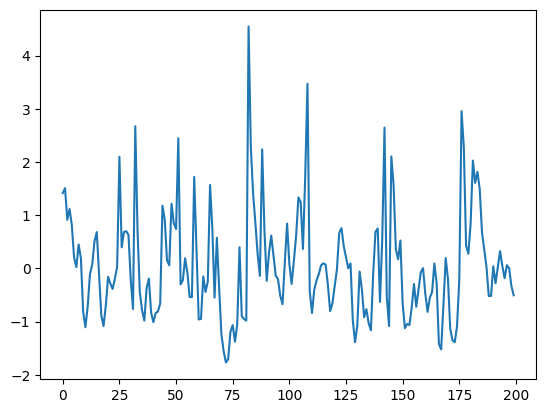

In [16]:
ds_fact = 500
ds_idx = end_idx // ds_fact
xt_ds = xt[::ds_fact]
plt.plot(xt_ds)


In [19]:
# Solver-specific parameters for sparsity
solver_d_kwargs = {
    'tol': 1e-3,
    'maxiter': 1000,
    'factr': 1e5,
    'pgtol': 1e-3,
    'l1_ratio': 0.01  # Uncomment if your solver supports this
}

params = {
    "n_times_atom": 250,  # L   # T
    "n_atoms": 3,         # K      # N
    "n_iter": 3,
    "reg":0.01,
    "random_state": 60,
    "n_jobs": 4,
    "verbose": 10,
}



csc = CDLTrainer(**params, solver_d_kwargs=solver_d_kwargs)
csc.fit_csc(loader.train)



Coordinate descent loop 0 / 3 [n_jobs=4]
[seed 60] Objective (z_hat) : 101496.95189674
Using method dual for projection
[seed 60] Objective (d) 89210.47080656
Coordinate descent loop 1 / 3 [n_jobs=4]
[seed 60] Objective (z_hat) : 33791.05394263
Using method dual for projection
[seed 60] Objective (d) 29153.84026817
Coordinate descent loop 2 / 3 [n_jobs=4]
[seed 60] Objective (z_hat) : 17783.65399942
Using method dual for projection
[seed 60] Objective (d) 17352.52694226
0.11524283055795986
0.0
0.5935685080959892


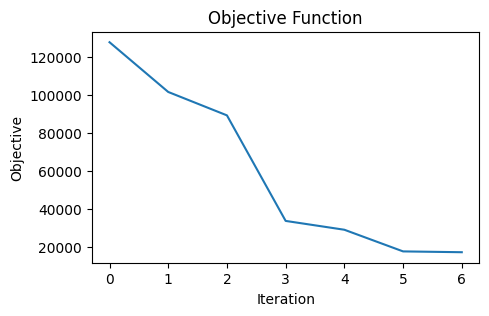

In [59]:
zer = CDLAnalyzer(csc, loader)
zer.compute_z_and_x_hat()
zer.compute_mses()
zer.plot_pobjective()

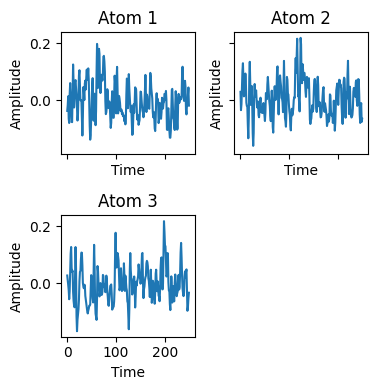

In [60]:
zer.plot_atoms()

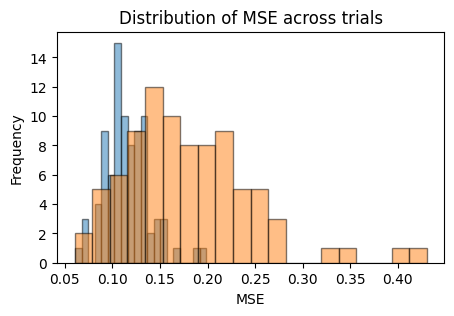

In [61]:
zer.plot_mse_distribution()

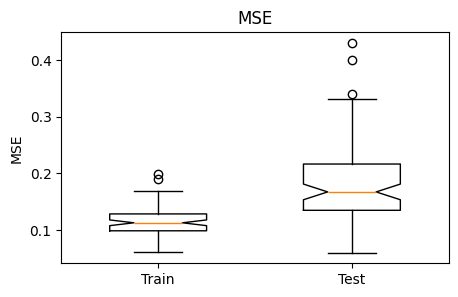

In [62]:
zer.mse_boxplot()

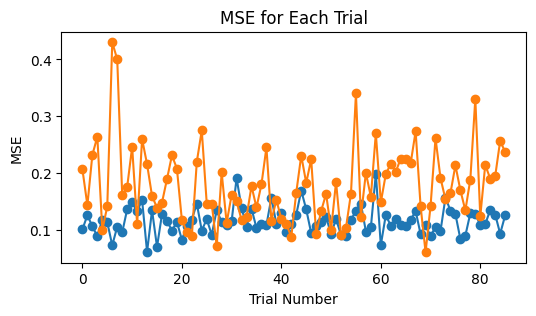

In [63]:
zer.plot_mse_by_trial()

In [69]:
zer.test_mse
# loader.test.shape


0.18011407737543425

In [68]:
zer.test_x_hat.shape

(86, 1, 1013)

In [82]:
zer.test_x_hat.shape

(86, 1013)

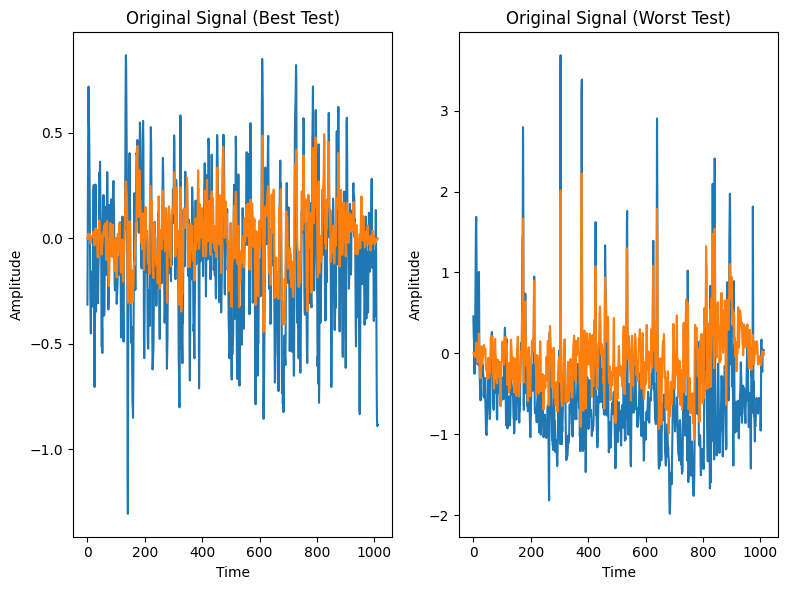

In [83]:
zer.plot_best_and_worst_reconstructions()


In [39]:
def plot_activation_strengths():
    """
    Plots the original signal and activation strengths for each atom on separate rows.
    
    Parameters:
    - x_test (np.ndarray): Original test signal of shape (n_times,).
    - z_test (np.ndarray): Activation coefficients of shape (n_atoms, n_times).
    """
    n_atoms, _ = z_hat.shape
    
    fig, axes = plt.subplots(n_atoms + 1, 1, figsize=(4, 1 * (n_atoms + 1)), sharex=True)
    # Plot original signal
    axes[0].plot(x, color='black')
    axes[0].set_title('Original Signal')
    axes[0].set_ylabel('Amplitude')
    
    # Plot activation strengths for each atom
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # One color for each atom
    for atom in range(n_atoms):
        axes[atom + 1].plot(z_hat[atom, :], color=colors[atom])
        axes[atom + 1].set_title(f'Atom {atom + 1} Activation')
        axes[atom + 1].set_ylabel('Activation')
    
    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()

# Call the function with the existing data
plot_activation_strengths(loader.train[0, :10000], z_hat[:,0, :10000])

TypeError: plot_activation_strengths() takes 0 positional arguments but 2 were given